## Task 4: RFM Analysis (Customer Segmentation)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#### Load and Prepare the Data

In [29]:
# Load the cleaned data from a CSV file into a Pandas DataFrame
data = pd.read_csv('cleaned_data.csv')
data['CustomerID']=data['CustomerID'].astype('Int64')
# Convert the 'InvoiceDate' column to a datetime format for accurate date and time operations
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


#### Calculate RFM Metrics

In [30]:
# Define a reference date to calculate Recency
# Using the maximum InvoiceDate in the dataset and adding 1 day to ensure the calculation of the days since the last purchase is accurate

analysis_date = data['InvoiceDate'].max() + pd.DateOffset(days=1)

# Calculate RFM metrics for each customer
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,# Recency: Calculate days since the last purchase
    'InvoiceNo': 'nunique',                                 # Frequency: Count the number of unique invoices (purchases)
    'TotalPrice': 'sum'                                     # Monetary: Sum up the total price spent by the customer
}).reset_index()

# Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

print(rfm)

      CustomerID  Recency  Frequency  Monetary
0          12346      326          1  77183.60
1          12347        2          7   4310.00
2          12348       75          4   1797.24
3          12349       19          1   1757.55
4          12350      310          1    334.40
...          ...      ...        ...       ...
4334       18280      278          1    180.60
4335       18281      181          1     80.82
4336       18282        8          2    178.05
4337       18283        4         16   2094.88
4338       18287       43          3   1837.28

[4339 rows x 4 columns]


#### Segment Customers

In [31]:
# Define quantile-based thresholds for all three RFM metrics
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.33, 0.66]).to_dict()

def segment_customer(row):
    # Recency segmentation: lower recency is better (closer purchases)
    if row['Recency'] <= quantiles['Recency'][0.33]:
        recency_score = 'High'
    elif row['Recency'] <= quantiles['Recency'][0.66]:
        recency_score = 'Medium'
    else:
        recency_score = 'Low'

    # Frequency segmentation: higher frequency is better
    if row['Frequency'] >= quantiles['Frequency'][0.66]:
        frequency_score = 'High'
    elif row['Frequency'] >= quantiles['Frequency'][0.33]:
        frequency_score = 'Medium'
    else:
        frequency_score = 'Low'

    # Monetary segmentation: higher monetary is better
    if row['Monetary'] >= quantiles['Monetary'][0.66]:
        monetary_score = 'High'
    elif row['Monetary'] >= quantiles['Monetary'][0.33]:
        monetary_score = 'Medium'
    else:
        monetary_score = 'Low'

    # Combine scores into a single segment
    if recency_score == 'High' and frequency_score == 'High' and monetary_score == 'High':
        return 'High'
    elif (
        (recency_score == 'Medium' and frequency_score in ['High', 'Medium'] and monetary_score in ['High', 'Medium']) or
        (frequency_score == 'Medium' and recency_score in ['High', 'Medium'] and monetary_score in ['High', 'Medium']) or
        (monetary_score == 'Medium' and recency_score in ['High', 'Medium'] and frequency_score in ['High', 'Medium'])
    ):
        return 'Medium'
    else:
        return 'Low'

# Apply the updated segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)



#### Visualize Customer Distribution

C:\Users\Dell\AppData\Local\Temp\ipykernel_82556\3636235019.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='viridis', order=segment_order)
C:\Users\Dell\AppData\Local\Temp\ipykernel_82556\3636235019.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='viridis')


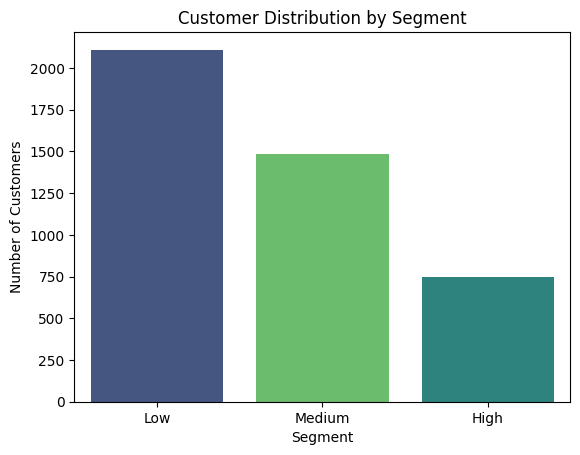

In [32]:
# Define the desired order of segments
segment_order = ['Low', 'Medium', 'High']

# Plot the distribution with sorted segments
sns.countplot(data=rfm, x='Segment', palette='viridis', order=segment_order)

# Plot the distribution
sns.countplot(data=rfm, x='Segment', palette='viridis')
plt.title('Customer Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()